# problem 2 a

In [1]:
import pandas as pd
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
from sklearn import linear_model,metrics,preprocessing,tree,model_selection
import matplotlib.pyplot as plt
from sklearn.externals.six import StringIO

import pydotplus
from IPython.display import Image
import random
import math
from scipy.stats import mode
from sklearn.metrics import accuracy_score

data = pd.read_csv('allhyper.data')
#data preprocess
data['class'].replace(to_replace=['T3 toxic.','goitre.','negative.','hyperthyroid.'],value=[0,0,0,1],inplace=True)
data['sex'].replace(to_replace=['F','M'],value=[0,1],inplace=True)
data.replace(to_replace=['f','t'],value=[0,1],inplace=True)
data['refSource'].replace(to_replace=['other','SVI','SVHC','STMW','SVHD'],value=[0,1,2,3,4],inplace=True)


y = data[['class']]
data.drop(['class','TBGInd','TBG'],axis=1,inplace=True)
X=data
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,test_size=0.3,random_state=3 )
values = {'sex': (X_train['sex'].mode()[0]),
          'onThyroxine':(X_train['onThyroxine'].mode()[0]),
           'queryOnThyroxine': (X_train['queryOnThyroxine'].mode()[0]),
          'onAntithyroidMed': (X_train['onAntithyroidMed'].mode()[0]),
          'sick': (X_train['sick'].mode()[0]),
          'preg': (X_train['preg'].mode()[0]),
          'thySurg': (X_train['thySurg'].mode()[0]),
          'I131': (X_train['I131'].mode()[0]),
          'queryHypothyroid': (X_train['queryHypothyroid'].mode()[0]),
          'queryHyperthyroid': (X_train['queryHyperthyroid'].mode()[0]),
          'lithium': (X_train['lithium'].mode()[0]),
          'goitre': (X_train['goitre'].mode()[0]),
          'tumor': (X_train['tumor'].mode()[0]),
          'hypopituitary': (X_train['hypopituitary'].mode()[0]),
          'psych': (X_train['psych'].mode()[0]),
          'TSHInd': (X_train['TSHInd'].mode()[0]),
          'T3Ind': (X_train['T3Ind'].mode()[0]),
           'TT4Ind': (X_train['TT4Ind'].mode()[0]),
           'T4UInd': (X_train['T4UInd'].mode()[0]),
           'FTIInd': (X_train['FTIInd'].mode()[0]),
            'refSource': (X_train['refSource'].mode()[0]),
            'age':(nanmean(X_train['age'])),
            'TSH':(nanmean(X_train['TSH'])),
            'T3':(nanmean(X_train['T3'])),
            'TT4':(nanmean(X_train['TT4'])),
          'T4U':(nanmean(X_train['T4U'])),
          'FTI':(nanmean(X_train['FTI'])),
         }
                     
X_train=np.array(X_train.fillna(value=values))
X_test=np.array(X_test.fillna(value=values))


y_train=(np.array(y_train))[:,0]
y_test=(np.array(y_test))[:,0]

In [2]:
'''
    Implement  get subsample
    Parameters
    ----------
   input:
    Xarray,yarray: features and labels of train set
   
   output:
    X_one, y_one :features and labels of subsample
    Xnochoose,ynochoose: those not been choosed by bootstrap
    '''
def get_subsample(Xarray,yarray):  
    sub_index = np.random.randint(0, len(yarray), size=(len(yarray)))
    X_one = Xarray[sub_index, :]
    y_one = yarray[sub_index].transpose()

    nochoose_index=list(set(np.arange(len(yarray)))-set(sub_index))

    X_nochoose = Xarray[nochoose_index, :]
    y_nochoose = yarray[nochoose_index].transpose()
    
    return X_one,y_one,X_nochoose,y_nochoose,nochoose_index  

def random_forest(Xarray,yarray,Xnew,nest,criterion, maxDepth, minStamplesLeaf):
#    mytree=[]
    ypred=[]
    ynew=[]
    ypred_no=[]
    yoob=np.arange(nest*len(yarray)).reshape((nest,len(yarray)))
    yoob[0]=np.zeros(len(yarray))
    for i in range(nest):
        Xsub,ysub,Xno,yno,nochoose_index=get_subsample(Xarray,yarray)
        clf = tree.DecisionTreeClassifier(max_features='sqrt',max_depth = maxDepth, min_samples_leaf = minStamplesLeaf,criterion=criterion,random_state=1 )
        clf.fit(Xsub,ysub)
#        mytree.append(clf)
        ypred.append(clf.predict(Xnew))

        ypred_no=clf.predict(Xno)
        
        j=0
        for item in nochoose_index:            
            yoob[i][item]=ypred_no[j]
            j=j+1

    y=mode(ypred)
    ynew=y.mode[0]

    yno=mode(yoob)
    yno_hat=yno.mode[0]
   
    oob_accuracy=accuracy_score(yarray, yno_hat)
#    oob_accuracy=metrics.fbeta_score(yarray, yno_hat,beta=2)

    return ynew,oob_accuracy        

def important_feature(Xarray,yarray,Xnew,nest,criterion, maxDepth, minStamplesLeaf):

    accuracy=[]
    for i in range(27):
        X = np.delete(Xarray,i,axis=1)
        Xtest=np.delete(Xnew,i,axis=1)
        p,cc1=random_forest(X,yarray,Xtest,nest,criterion, maxDepth, minStamplesLeaf)
        accuracy.append(cc1)
    
#    feature_index=accuracy.index(min(accuracy))
    feature_index=np.argsort(accuracy)
    return feature_index
    

# problem 2 b

In [4]:
#find the best parameter when gini
nest=np.arange(10, 26)
maxDepth=np.arange(3,13)
minStamplesLeaf=np.arange(1,10)
accuracy_list=np.zeros((16,10,9))

for n in nest:
    for dep in maxDepth:
        for lef in minStamplesLeaf:
            z,cc=random_forest(X_train,y_train,X_test,n,'gini',dep,lef)
            accuracy_list[n-10][dep-3][lef-1]=accuracy_score(y_test, z) 

re=np.where(accuracy_list==np.max(accuracy_list))
n=re[0][0]+10
dep=re[1][0]+3
lef=re[2][0]+1
print(n,dep,lef)


10 11 3


In [13]:
accuracy_list[0][8][2]

0.98809523809523814

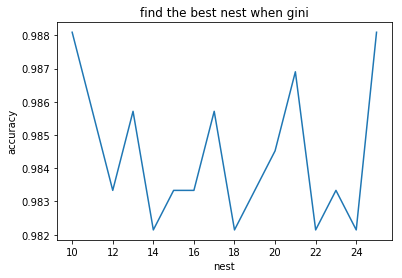

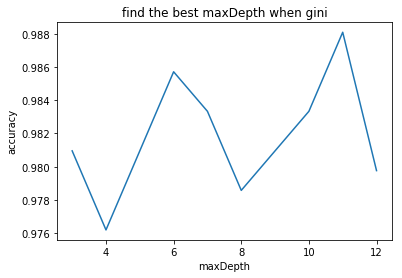

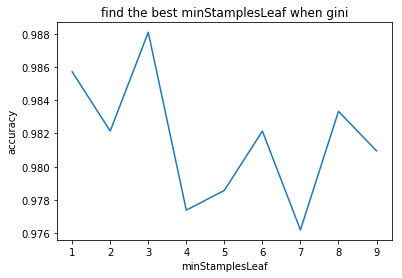

In [11]:
#gini.show the plots when 3 parameters are fixed in the best value
#nest
nest=np.arange(10,26)
accuracy1=[]
for n in nest:
    accuracy1.append(accuracy_list[n-10][dep-3][lef-1])
plt.plot(nest, accuracy1)
plt.xlabel('nest')
plt.ylabel('accuracy')
plt.title('find the best nest when gini')
plt.axis('tight')
plt.show()

#depth
n=re[0][0]+10
maxDepth=np.arange(3,13)
accuracy2=[]
for dep in maxDepth:
    accuracy2.append(accuracy_list[n-10][dep-3][lef-1])  
plt.plot(maxDepth, accuracy2)
plt.xlabel('maxDepth')
plt.ylabel('accuracy')
plt.title('find the best maxDepth when gini')
plt.axis('tight')
plt.show()

#lef
dep=re[1][0]+3
minStamplesLeaf=np.arange(1,10)
accuracy3=[]
for lef in minStamplesLeaf:
    accuracy3.append(accuracy_list[n-10][dep-3][lef-1]) 
plt.plot(minStamplesLeaf, accuracy3)
plt.xlabel('minStamplesLeaf')
plt.ylabel('accuracy')
plt.title('find the best minStamplesLeaf when gini')
plt.axis('tight')
plt.show()

In [14]:
#find the best parameter when entropy
nest=np.arange(10, 26)
maxDepth=np.arange(3,13)
minStamplesLeaf=np.arange(1,10)
accuracy_list2=np.zeros((16,10,9))

for n in nest:
    for dep in maxDepth:
        for lef in minStamplesLeaf:
            z,cc=random_forest(X_train,y_train,X_test,n,'entropy',dep,lef)
            accuracy_list2[n-10][dep-3][lef-1]=accuracy_score(y_test, z) 
re=np.where(accuracy_list2==np.max(accuracy_list2))
n=re[0][0]+10
dep=re[1][0]+3
lef=re[2][0]+1
print(n,dep,lef)            

13 6 1


In [15]:
accuracy_list[3][3][0]

0.98095238095238091

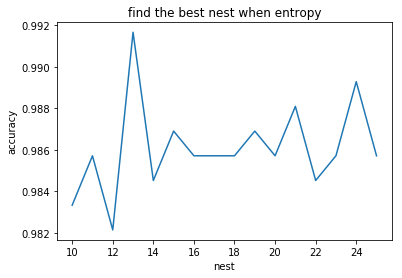

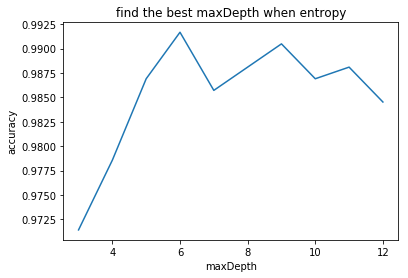

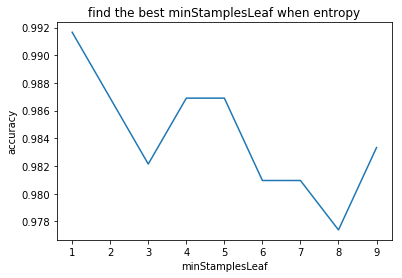

In [17]:
#entropy.show the plots when 3 parameters are fixed in the best value
#nest
nest=np.arange(10,26)
accuracy1=[]
for n in nest:
    accuracy1.append(accuracy_list2[n-10][dep-3][lef-1])
plt.plot(nest, accuracy1)
plt.xlabel('nest')
plt.ylabel('accuracy')
plt.title('find the best nest when entropy')
plt.axis('tight')
plt.show()

#depth
n=re[0][0]+10
maxDepth=np.arange(3,13)
accuracy2=[]
for dep in maxDepth:
    accuracy2.append(accuracy_list2[n-10][dep-3][lef-1])  
plt.plot(maxDepth, accuracy2)
plt.xlabel('maxDepth')
plt.ylabel('accuracy')
plt.title('find the best maxDepth when entropy')
plt.axis('tight')
plt.show()

#lef
dep=re[1][0]+3
minStamplesLeaf=np.arange(1,10)
accuracy3=[]
for lef in minStamplesLeaf:
    accuracy3.append(accuracy_list2[n-10][dep-3][lef-1]) 
plt.plot(minStamplesLeaf, accuracy3)
plt.xlabel('minStamplesLeaf')
plt.ylabel('accuracy')
plt.title('find the best minStamplesLeaf when entropy')
plt.axis('tight')
plt.show()

# problem 2 c

In [18]:
#using the best parameters
z,cc=random_forest(X_train,y_train,X_test,10,'gini',11,3)  #'entropy' 

accuracy0=accuracy_score(y_test, z) 
print('The test accuracy of the best model is',accuracy0)
print('The OOB sample accuracy is',cc)


The test accuracy of the best model is 0.985714285714
The OOB sample accuracy is 0.985204081633


# problem 2 d

In [19]:

feature=important_feature(X_train,y_train,X_test,10,'gini',11,3)
data.columns[feature]

Index(['TSH', 'lithium', 'T3Ind', 'TT4Ind', 'T4UInd', 'onThyroxine',
       'onAntithyroidMed', 'T3', 'I131', 'TSHInd', 'hypopituitary', 'goitre',
       'TT4', 'FTIInd', 'queryHyperthyroid', 'queryOnThyroxine', 'sex', 'T4U',
       'queryHypothyroid', 'thySurg', 'preg', 'FTI', 'tumor', 'sick', 'psych',
       'age', 'refSource'],
      dtype='object')

In [20]:
print('the most important feature is ', data.columns[feature][0])

the most important feature is  TSH
